In [4]:
from _tests import scripts
from scripts import utils, notebook_utils
import numpy as np
import matplotlib.pyplot as plt

MACRO_NAME = "flexdcim_2025"

# Model of "FlexDCIM: A 400 MHz 249.1 TOPS/W 64 Kb Flexible Digital Compute-in-Memory SRAM Macro for CNN Acceleration"

Paper by Vishal Sharma, Xin Zhang, Narendra Singh Dhakad, and Tony Tae-Hyoung Kim

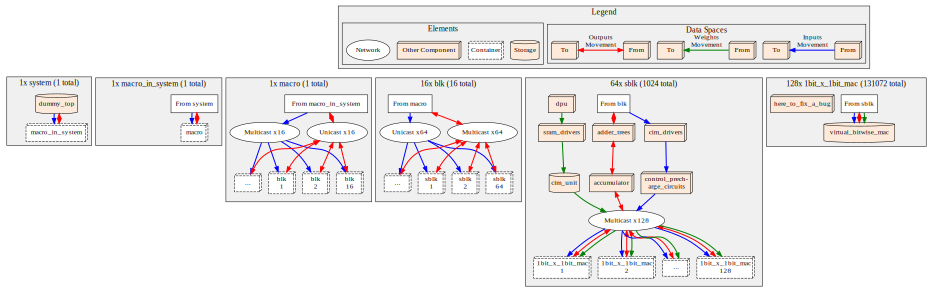

In [28]:
notebook_utils.display_diagram(notebook_utils.get_diagram(
    "flexdcim_2025",
    # ignore=DIAGRAM_DEFAULT_IGNORE,
))

In [3]:
# utils.get_spec(
#     macro=MACRO_NAME
# )

In [5]:
# TODO: check that these components are in the correct sections

# used for area and power breakdowns
memory_components = ["dpu", "cim_unit"]
adder_tree_components = ["adder_trees"]
ctrl_components = ["control_precharge_circuits", "accumulator"]
cim_drv_components = ["cim_drivers"]
wl_drv_components = ["sram_drivers"]

## Area Breakdown

This test replicates the results presented in Fig. 24 of the paper.

We show the area breakdown of the macro. The area is broken down into the following parts:
* Memory: <TODO: explanation of part>
* Adder Tree: <TODO: explanation of part>
* Control (CTRL): <TODO: explanation of part>
* CiM Driver: <TODO: explanation of part>
* WL Driver: <TODO: explanation of part>

<TODO: brief analysis of results>
* memory/bitcell array consumes the most memory
* adder tree second most

---

From Table VI:
* macro area: 0.3136 mm^2 (313,600 µm^2)
* bit-cell area: 2.3452 µm^2

Targets:
* Memory: 52.85%
* Adder Tree: 34.72%
* CTRL: 4.38%
* CIM_DRV: 4.45%
* WL_DRV: 3.60%

In [194]:
macro_area = 313_600e-12 # 313,600 µm^2

results = utils.single_test(
    utils.quick_run(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            # INPUT_BITS=1,
            # WEIGHT_BITS=8,
            # OUTPUT_BITS=16,
            # FORCE_100MHZ=True,
        ),
    )
)

In [195]:
[x for x in results[0].per_component_area.items() if x[1] > 0]

[('dpu', 1.4914662400000002e-07),
 ('adder_trees', 1.16334592e-07),
 ('sram_drivers', 8.77186048e-09),
 ('cim_drivers', 1.0964787200000001e-08),
 ('control_precharge_circuits', 1.694976e-09),
 ('accumulator', 1.52461312e-08),
 ('cim_unit', 1.3844479999999999e-08)]

In [196]:
results.combine_per_component_area(memory_components, "Memory")
results.add_compare_ref_area("Memory", 0.5285 * macro_area)
results.combine_per_component_area(adder_tree_components, "Adder Tree")
results.add_compare_ref_area("Adder Tree", 0.3472 * macro_area)
results.combine_per_component_area(ctrl_components, "CTRL")
results.add_compare_ref_area("CTRL", 0.0438 * macro_area)
results.combine_per_component_area(cim_drv_components, "CIM_DRV")
results.add_compare_ref_area("CIM_DRV", 0.0445 * macro_area)
results.combine_per_component_area(wl_drv_components, "WL_DRV")
results.add_compare_ref_area("WL_DRV", 0.0360 * macro_area)
# results.clear_zero_areas()

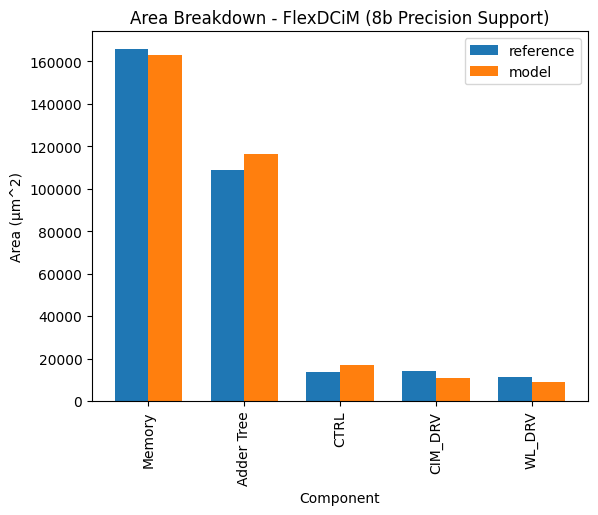

MEMORY AREA: scales roughly linearly with the precision due to the fact that each weight requires a DPU, going from 8b to 16b we should see area roughly double (it does) 

ADDER AREA: sub-linear increase in area with an increase in precision due to the fact that for inrceases in precision, the width of the addders must expand, but the total depth does not necessarily (the number of bits it takes to represent the sum of two 8b numbers is 9b) Still working on calibrating this part, hope to get it done so that we can slap a correct 16b extended area plot on 

CTRL AREA: should be pretty much constant, as the control logic represents a fixed cost (multiplexors and routing hardware, not required to necesarilt store inputs and weights or anything like the DPUs 

CIM DRVR AREA and SRAM DRVR AREA: Both of these require wider buses for driving inputs/weights as precision scales up so do increase (not linearly as the drivers basically consist of the controller sending values and the buses across

In [197]:
notebook_utils.bar_side_by_side(
    results[0].get_compare_ref_area()*1e12,
    xlabel="Component",
    ylabel="Area (µm^2)",
    title="Area Breakdown - FlexDCiM (8b Precision Support)",
)

print("MEMORY AREA: scales roughly linearly with the precision due to the fact that each weight requires a DPU, going from 8b to 16b we should see area roughly double (it does) \n")
print("ADDER AREA: sub-linear increase in area with an increase in precision due to the fact that for inrceases in precision, the width of the addders must expand, but the total depth does not necessarily (the number of bits it takes to represent the sum of two 8b numbers is 9b) Still working on calibrating this part, hope to get it done so that we can slap a correct 16b extended area plot on \n")
print("CTRL AREA: should be pretty much constant, as the control logic represents a fixed cost (multiplexors and routing hardware, not required to necesarilt store inputs and weights or anything like the DPUs \n")
print("CIM DRVR AREA and SRAM DRVR AREA: Both of these require wider buses for driving inputs/weights as precision scales up so do increase (not linearly as the drivers basically consist of the controller sending values and the buses across which they are sent, again the controller here is a near-fixed area cost, and so the area scales sub-linearly (doubling the number of wires (precision) won't double the area of the whole driver \n)")

## Power Breakdown

This test replicates the results presented in Fig. 24 of the paper.

We show the power breakdown of the macro. The power is broken down into the following parts:
* Memory: <TODO: explanation of part>
* Adder Tree: <TODO: explanation of part>
* Control (CTRL): <TODO: explanation of part>
* CiM Driver: <TODO: explanation of part>

Notably, the power contribution of the WL Driver is 0.0% because, as stated in the paper, "for CIM mode, the CIM Driver module controls the wordlines. Hence the power consumption of the WL driver has been considered under the CIM driver block."

<TODO: brief analysis of results>
* ctrl is the most
* adder tree and memory follow

---

Targets:
* Memory: 19.4%
* Adder Tree: 23.8%
* CTRL: 44.0%
* CIM_DRV: 12.8%
* WL_DRV: 0.0%, "For CIM mode, the CIM Driver
module controls the wordlines. Hence the power consumption
of the WL driver has been considered under the CIM driver
block."

In [184]:
results = utils.single_test(
    utils.quick_run(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            # INPUT_BITS=1,
            # WEIGHT_BITS=8,
            # OUTPUT_BITS=16,
            # FORCE_100MHZ=True,
        ),
    )
)

In [185]:
[x for x in results[0].per_component_energy.items() if x[1] > 0]

[('cim_unit', 2.13909504e-14),
 ('accumulator', 5.431623680000001e-13),
 ('control_precharge_circuits', 7.9691776e-12),
 ('cim_drivers', 1.71966464e-12),
 ('sram_drivers', 7.80140544e-25),
 ('adder_trees', 4.55081984e-12),
 ('dpu', 4.2467328e-12)]

In [186]:
# measured by pJ/full array of MACs, so multiply all by 512 x 128 (?)
total_energy = .0003

results.combine_per_component_energy(memory_components, "Memory")
results.add_compare_ref_energy("Memory", 0.194 * total_energy * 512 * 128 * 1e-12)
results.combine_per_component_energy(adder_tree_components, "Adder Tree")
results.add_compare_ref_energy("Adder Tree", 0.238 * total_energy * 512 * 128 * 1e-12)
results.combine_per_component_energy(ctrl_components, "CTRL")
results.add_compare_ref_energy("CTRL", 0.440 * total_energy * 512 * 128 * 1e-12)
results.combine_per_component_energy(cim_drv_components, "CIM_DRV")
results.add_compare_ref_energy("CIM_DRV", 0.128 * total_energy * 512 * 128 * 1e-12)
results.combine_per_component_energy(wl_drv_components, "WL_DRV")
results.add_compare_ref_energy("WL_DRV", 0)

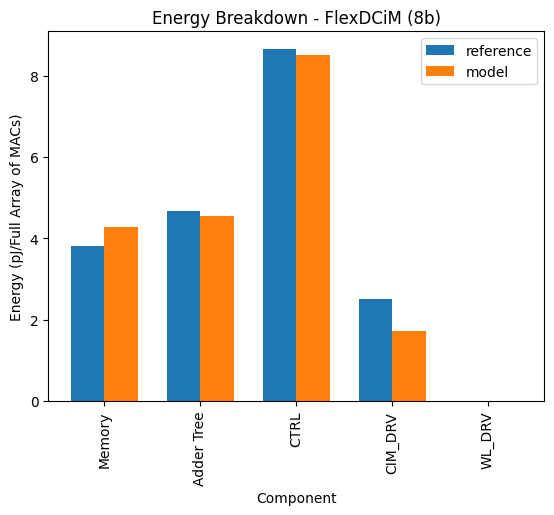

Energy Breakdown Comparison (pJ/Full Array of MACs):
Component       Reference       Model           Ratio (Model/Ref)
------------------------------------------------------------
Memory          3.81            4.27            1.1190         
Adder Tree      4.68            4.55            0.9725         
CTRL            8.65            8.51            0.9840         
CIM_DRV         2.52            1.72            0.6833         
WL_DRV          0.00            0.00            inf            
------------------------------------------------------------
TOTAL           19.66           19.05           0.9690         


In [187]:
notebook_utils.bar_side_by_side(
    results[0].get_compare_ref_energy()*1e12,
    xlabel="Component",
    ylabel="Energy (pJ/Full Array of MACs)",
    title="Energy Breakdown - FlexDCiM (8b)",
)

# GPT script for printing the actual values to debug
# Print reference and model values for comparison
print("Energy Breakdown Comparison (pJ/Full Array of MACs):")
print("{:<15} {:<15} {:<15} {:<15}".format("Component", "Reference", "Model", "Ratio (Model/Ref)"))
print("-" * 60)

energy_data = results[0].get_compare_ref_energy() * 1e12  # Convert to pJ
for component in energy_data:
    ref_value = energy_data[component]["reference"]
    model_value = energy_data[component]["model"] if "model" in energy_data[component] else 0
    ratio = model_value / ref_value if ref_value > 0 else float('inf')
    print("{:<15} {:<15.2f} {:<15.2f} {:<15.4f}".format(component, ref_value, model_value, ratio))

# Calculate total energy
total_ref = sum([energy_data[comp]["reference"] for comp in energy_data])
total_model = sum([energy_data[comp]["model"] if "model" in energy_data[comp] else 0 for comp in energy_data])
total_ratio = total_model / total_ref if total_ref > 0 else float('inf')
print("-" * 60)
print("{:<15} {:<15.2f} {:<15.2f} {:<15.4f}".format("TOTAL", total_ref, total_model, total_ratio))

## Energy Efficiency

This test replicates the results presented in Fig. 23 of the paper.

---

Measured in TOPS/W

100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


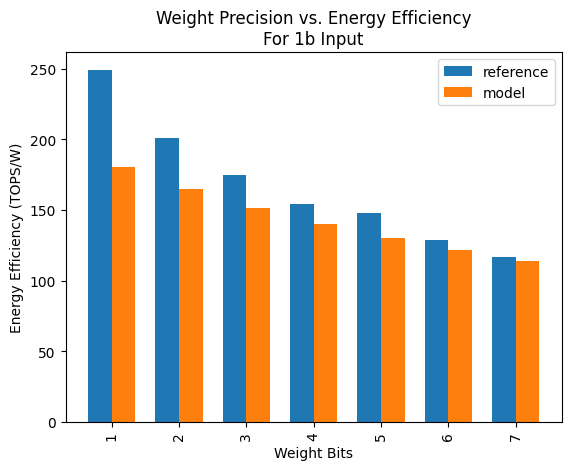

In [188]:
EXPECTED_EFFICIENCY_1b_INPUT = {
    1: 249.1,
    2: 201.0,
    3: 175.0,
    4: 153.9,
    5: 148.0,
    6: 129.0,
    7: 117.0,
    8: 110.7,
}

results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=i,
            INPUT_BITS=1,
        ),
    )
    for i in range(1, 8)
)

expected_flattened = list(EXPECTED_EFFICIENCY_1b_INPUT.values())
for r, e in zip(results, expected_flattened):
    r.add_compare_ref("tops_per_w", e)

notebook_utils.bar_side_by_side(
    {r.variables["WEIGHT_BITS"]: r.tops_per_w for r in results},
    # ax=axs[i],
    xlabel="Weight Bits",
    ylabel="Energy Efficiency (TOPS/W)",
    title=f"Weight Precision vs. Energy Efficiency\nFor 1b Input",
)

100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


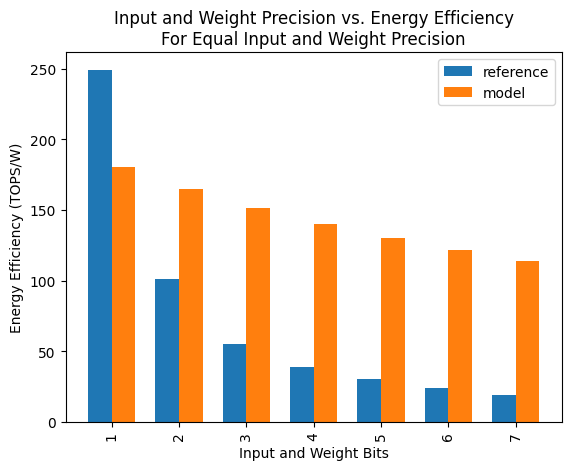

In [189]:
EXPECTED_EFFICIENCY_SCALED_INPUT = {
    1: 249.1,
    2: 101.0,
    3: 55.0,
    4: 38.5,
    5: 30.0,
    6: 24.0,
    7: 19.0,
    8: 13.84,
}

results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            INPUT_BITS=i,
            WEIGHT_BITS=i,
        ),
    )
    for i in range(1, 8)
)

expected_flattened = list(EXPECTED_EFFICIENCY_SCALED_INPUT.values())
for r, e in zip(results, expected_flattened):
    r.add_compare_ref("tops_per_w", e)

notebook_utils.bar_side_by_side(
    {r.variables["WEIGHT_BITS"]: r.tops_per_w for r in results},
    # ax=axs[i],
    xlabel="Input and Weight Bits",
    ylabel="Energy Efficiency (TOPS/W)",
    title=f"Input and Weight Precision vs. Energy Efficiency\nFor Equal Input and Weight Precision",
)

In [66]:
i = 4

print(results[i].variables["WEIGHT_BITS"])
print(results[i].variables["INPUT_BITS"])
print(results[i].tops_per_w)

5
1
{'reference': 148.0, 'model': 75.52570725897077}


## Throughput

This test replicates the results presented in Table V of the paper.

---

Target: 819.2 GOPS

Test at 400 MHz

In [95]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=i,
            INPUT_BITS=j,
            # N_REGS_PER_COL=[1, 2, 4, 8, 16][j],
            # N_ROWS_PER_REG=128 // [1, 2, 4, 8, 16][j],
            # FORCE_100MHZ=False,
            # OUTPUT_BITS=16,
        ),
    )
    for i in (1, 8)
    for j in (1, 8)
)

# add attributes for GOPS, computed from results TOPS
for r in results:
    r.gops = (r.tops * 1e3) * (8 / r.variables["INPUT_BITS"])
    print(r.gops)

100%|██████████| 4/4 [00:06<00:00,  1.61s/it]

819.2
102.4
819.2
102.4


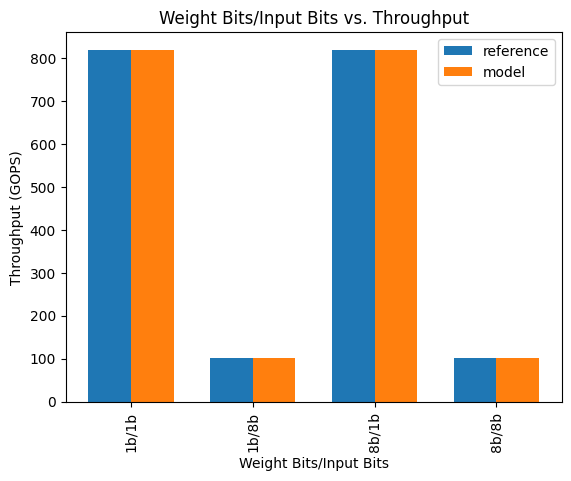

In [96]:
EXPECTED_THROUGHPUT = {
    # 1b~8b Weight /1b~8b Input
    "1b/1b": 819.2,
    "1b/8b": 102.4,
    "8b/1b": 819.2,
    "8b/8b": 102.4,
}

expected_flattened = list(EXPECTED_THROUGHPUT.values())
for r, e in zip(results, expected_flattened):
    r.add_compare_ref("gops", e)

notebook_utils.bar_side_by_side(
    {
        "1b/1b": results[0].gops,
        "1b/8b": results[1].gops,
        "8b/1b": results[2].gops,
        "8b/8b": results[3].gops,
    }, # TOPS -> GOPS
    # ax=axs[i],
    xlabel="Weight Bits/Input Bits",
    ylabel="Throughput (GOPS)",
    title=f"Weight Bits/Input Bits vs. Throughput",
)

## Weight Precision Scaling

This test presents our design space exploration, extending the results presented in the FlexDCIM paper by exploring how scaling the weight bit precision beyond 8b impacts other metrics of the macro.

---

TODO: what variables/component arguments need to be changed to accurately reflect changing weight precision >8b?

In [54]:
scaled_weights_precisions = [8, 12, 16, 24, 32]

In [55]:
dir(results[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_compare_ref',
 'access',
 'accesses',
 'add_compare_ref',
 'add_compare_ref_area',
 'add_compare_ref_energy',
 'aggregate',
 'aggregate_by',
 'area',
 'clear_zero_areas',
 'clear_zero_energies',
 'combine_per_component_area',
 'combine_per_component_area_energy',
 'combine_per_component_energy',
 'computes',
 'computes_1b',
 'computes_per_joule',
 'computes_per_joule_1b',
 'computes_per_second',
 'computes_per_second_1b',
 'computes_per_second_per_square_meter',
 'cycle_seconds',
 'cycles',
 'encoded_input_bits',
 'encoded_output_bits',
 'encoded_weight_bits',
 'energy',
 'from_output_stats',
 'get_compare_ref_area'

In [56]:
def multi_bar_plot(
    dicts,
    ylabel,
    title,
):
    # Component labels
    components = list(dicts[0].keys())
    n_components = len(components)
    n_dicts = len(dicts)

    # Convert dictionaries to values for each component
    values = [[d[c] for c in components] for d in dicts]

    # Plot setup
    x = np.arange(n_components)  # the label locations
    width = 0.15  # the width of the bars
    colors = plt.cm.viridis(np.linspace(0, 1, n_dicts))

    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(n_dicts):
        ax.bar(x + i * width, values[i], width, label=f"{scaled_weights_precisions[i]}b Weight", color=colors[i])

    # Labels and styling
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width * (n_dicts - 1) / 2)
    ax.set_xticklabels(components)
    ax.legend()
    # ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

## Area Analysis

Hypotheses:
* Scaling maximum precision of the architecture from 8b to 16b or 32b will significantly increase the area of the SBLKs, leading to a higher area cost
    * Scaling to 16b or 32b done by using 16 or 32 DPUs, respectively, per SBLK
    * 8-bit precision architecture contains 16 x 64 = 1024 SBLKs, thus an extension to 32b precision would mandate 16 x 64 x 24 = 24576 additional DPUs
* Binary adder trees must also increase in bitwidth in order to support the higher precision
* Area would thus scale in a linear fashion as a function of precision

In [57]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=w,
        ),
    )
    for w in scaled_weights_precisions
)

results.combine_per_component_area(memory_components, "Memory")
results.combine_per_component_area(adder_tree_components, "Adder Tree")
results.combine_per_component_area(ctrl_components, "CTRL")
results.combine_per_component_area(cim_drv_components, "CIM_DRV")
results.combine_per_component_area(wl_drv_components, "WL_DRV")
results.clear_zero_areas()

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


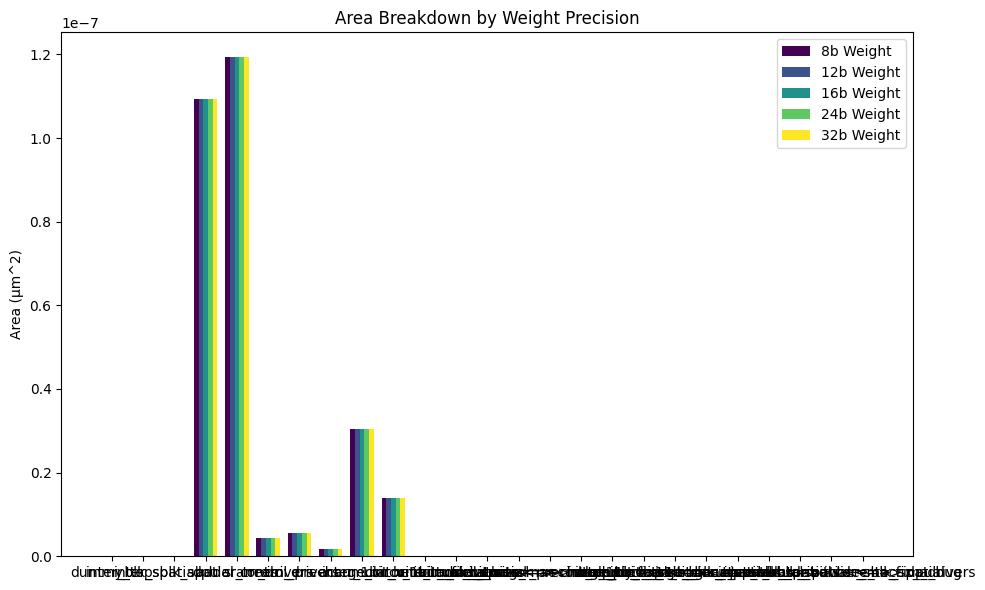

In [59]:
multi_bar_plot(
    [r.per_component_area for r in results],
    ylabel="Area (µm^2)",
    title="Area Breakdown by Weight Precision",
)

## Power Analysis

Hypotheses:
* Leakage power is estimated to scale linearly as well (as a function of transistor count)
* Design space exploration is makes no change to factors like technology node, so the leakage of each transistor as
dependent on technology node will not change
* The dominating increase in power leakage will occur due to the added transistors in additional DPUs and binary
adder tree logic
* Greater complexity of adder tree logic would likely lead to a reduction in clock frequency (longer critical paths in
adder trees may cause throughput to suffer)
* Increased precision will also increase data movement (moving more values into DPUs to store weights)

In [60]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=w,
        ),
    )
    for w in scaled_weights_precisions
)

results.combine_per_component_energy(memory_components, "Memory")
results.combine_per_component_energy(adder_tree_components, "Adder Tree")
results.combine_per_component_energy(ctrl_components, "CTRL")
results.combine_per_component_energy(cim_drv_components, "CIM_DRV")
results.combine_per_component_energy(wl_drv_components, "WL_DRV")
results.clear_zero_energies()

100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


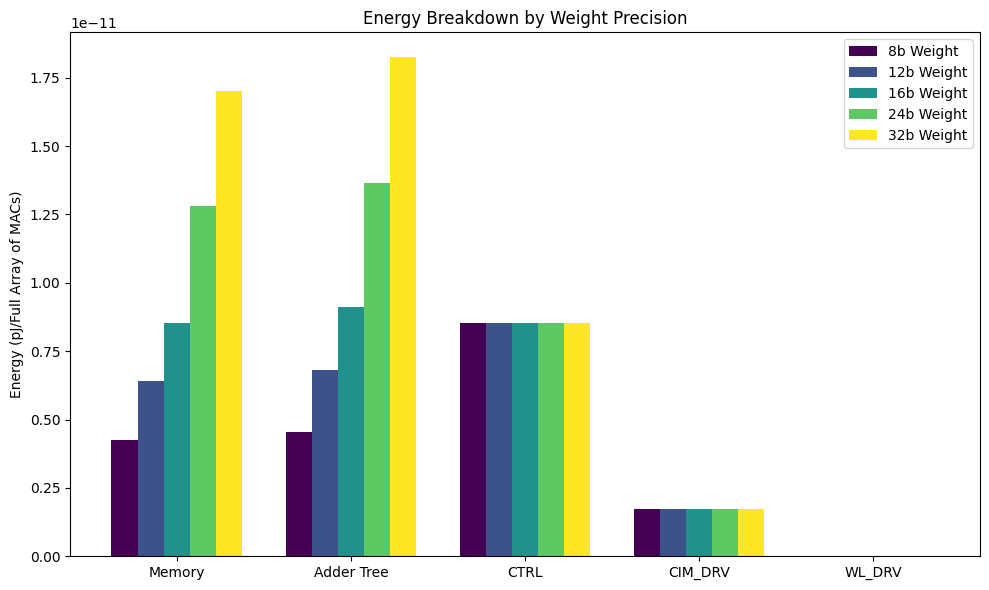

In [61]:
multi_bar_plot(
    [r.per_component_energy for r in results],
    ylabel="Energy (pJ/Full Array of MACs)",
    title="Energy Breakdown by Weight Precision",
)

## Energy Efficiency and Throughput

Hypotheses:
* Energy efficiency will continue to decrease, as seen in 1b~8b
* Throughput should remain constant, since input is bit-serial, but weight is bit-parallel
    * Weight precision scaling activates more hardware in parallel (DPUs), no extra cycles* 
    * Input precision scaling stretches the number of cycles per MAC, reducing throughput
    * FlexDCIM was designed to keep weight flexibility without penalizing performance

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


TypeError: 'float' object is not subscriptable

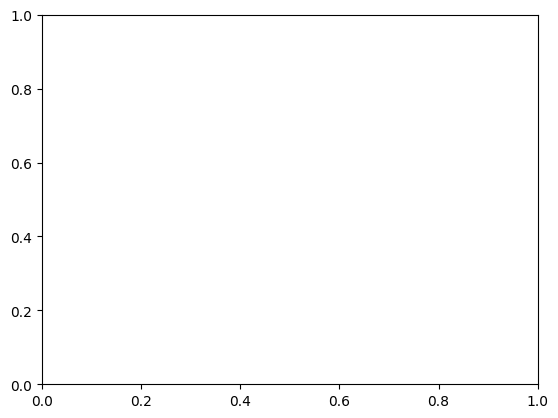

In [62]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=w,
            INPUT_BITS=1,
        ),
    )
    for w in scaled_weights_precisions
)

notebook_utils.bar_side_by_side(
    {r.variables["WEIGHT_BITS"]: r.tops_per_w for r in results},
    # ax=axs[i],
    xlabel="Weight Bits",
    ylabel="Energy Efficiency (TOPS/W)",
    title=f"Weight Precision vs. Energy Efficiency\nFor 1b Input",
)

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


TypeError: 'float' object is not subscriptable

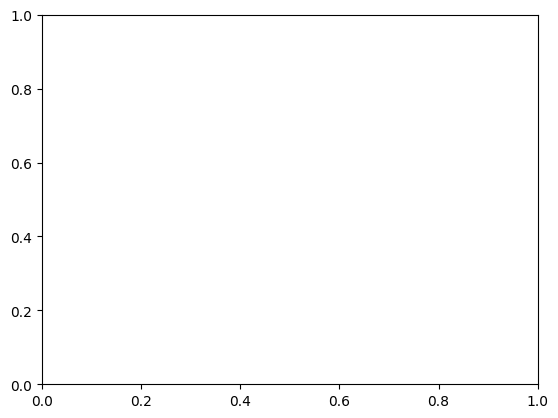

In [63]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=w,
            INPUT_BITS=8,
        ),
    )
    for w in scaled_weights_precisions
)

notebook_utils.bar_side_by_side(
    {r.variables["WEIGHT_BITS"]: r.tops_per_w for r in results},
    # ax=axs[i],
    xlabel="Input and Weight Bits",
    ylabel="Energy Efficiency (TOPS/W)",
    title=f"Weight Precision vs. Energy Efficiency\nFor 8b Input",
)

100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


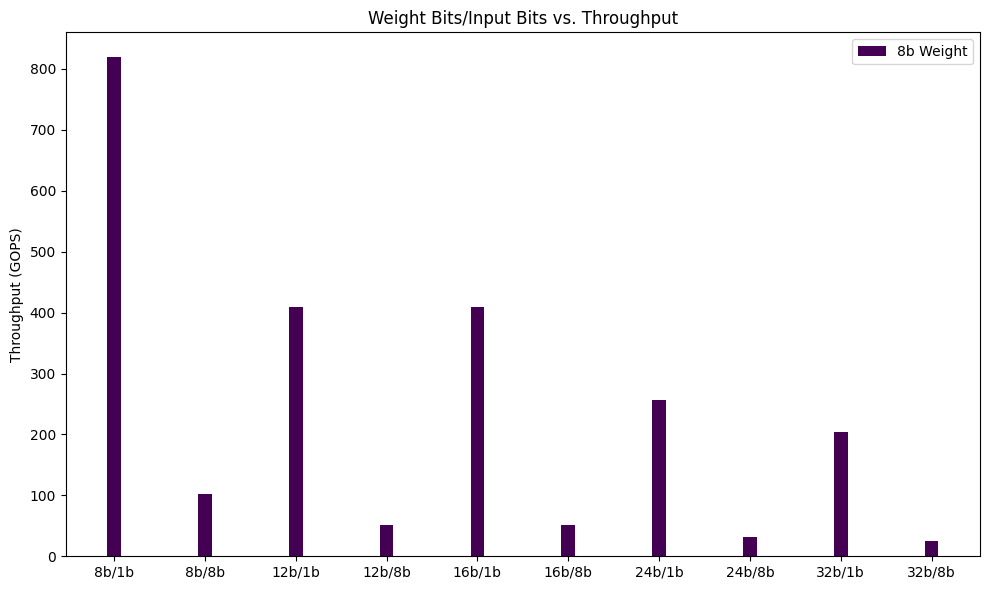

In [89]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=w,
            INPUT_BITS=i,
            # N_REGS_PER_COL=[1, 2, 4, 8, 16][j],
            # N_ROWS_PER_REG=128 // [1, 2, 4, 8, 16][j],
            # FORCE_100MHZ=False,
            # OUTPUT_BITS=16,
        ),
    )
    for w in scaled_weights_precisions
    for i in (1, 8)
)

# add attributes for GOPS, computed from results TOPS
for r in results:
    r.gops = r.tops * 1e3

data = {
    f"{t[0]}b/{t[1]}b": results[ix].gops
    for ix, t in enumerate(
        [(w, i) for w in scaled_weights_precisions for i in (1,8)]
    )
}

multi_bar_plot(
    [data],
    ylabel="Throughput (GOPS)",
    title="Weight Bits/Input Bits vs. Throughput"
)

## Misc. Analysis

* energy per MAC: expect to see an increase, especially due to switching activity and leakage (note: this was not evaluated in their paper)

100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


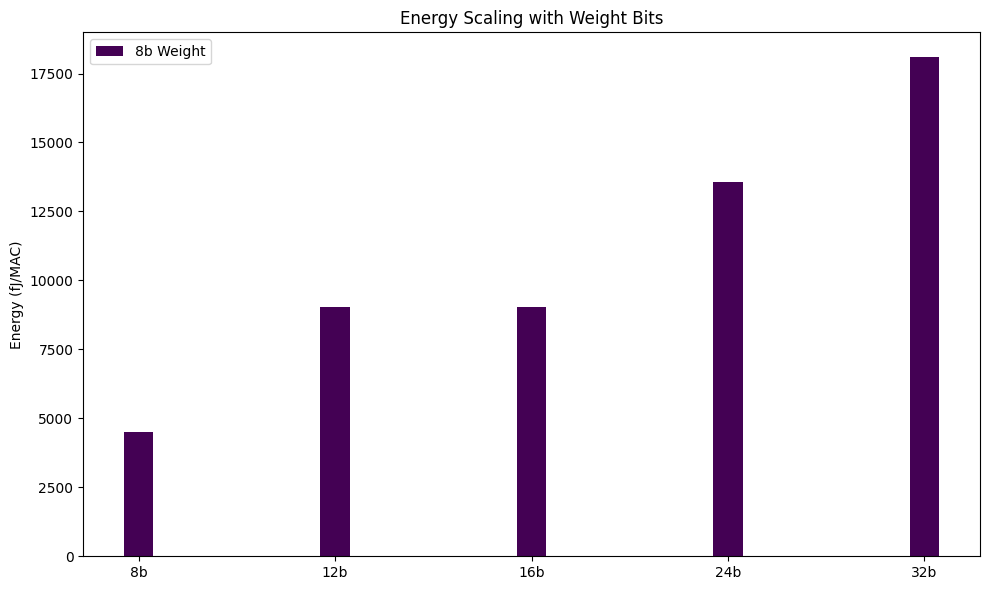

In [90]:
results = utils.parallel_test(
    utils.delayed(utils.quick_run)(
        macro=MACRO_NAME,
        variables=dict(
            MAX_UTILIZATION=True,
            WEIGHT_BITS=w,
            INPUT_BITS=8,
        ),
    )
    for w in scaled_weights_precisions
)

data = {
    f"{r.variables['WEIGHT_BITS']}b": r.per_compute("energy")*1e15
    for r in results
}

multi_bar_plot(
    [data],
    ylabel="Energy (fJ/MAC)",
    title="Energy Scaling with Weight Bits"
)